# Библиотека

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
import torch
import h5py
from pathlib import Path
import numpy as np
from torch.utils.data import Dataset
from pathlib import Path
import torch
import scipy.io as sio
import random
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
from IPython.display import clear_output, display

# DataLoader

In [34]:
class MultiTrajectoryGPDataset(Dataset):
    def __init__(
        self,
        mat_files,
        num_traj_per_batch=4,
        n_data_per_traj=2048, # Увеличил, A100 прожует легко
        n_f_per_traj=8192,    # Увеличил
        # device="cuda" -- УБИРАЕМ, датасет не должен знать о GPU
    ):
        super().__init__()
        self.mat_files = mat_files
        self.num_traj_per_batch = num_traj_per_batch
        self.n_data_per_traj = n_data_per_traj
        self.n_f_per_traj = n_f_per_traj

        # 1. Загружаем сетку (один раз) на CPU
        # map_location='cpu' критически важен!
        example = torch.load(mat_files[0], map_location='cpu')

        # Сразу делаем .float() и оставляем на CPU
        self.Nx, self.Ny, self.Nt = example["psi_real"].shape

        self.x = torch.linspace(-5, 5, self.Nx).float()
        self.y = torch.linspace(-5, 5, self.Ny).float()
        self.t = torch.linspace(0, 1, self.Nt).float()

  # 2. Загружаем все траектории в RAM (CPU)
        print(f"Loading {len(mat_files)} trajectories to RAM...")
        self.traj = []
        psi_r_list = []
        psi_i_list = []

        for f in mat_files:
            d = torch.load(f, map_location='cpu')
            for key in ["psi_real", "psi_imag"]:
                if d[key].is_cuda:
                    d[key] = d[key].cpu()

            psi_r = d["psi_real"].float()
            psi_i = d["psi_imag"].float()

            # Сохраняем в список для подсчёта mean/std
            psi_r_list.append(psi_r)
            psi_i_list.append(psi_i)

            self.traj.append({
                "psi_r": psi_r,
                "psi_i": psi_i,
                "omega_x": float(d["params"][0]),
                "omega_y": float(d["params"][1]),
                "g_param": float(d["params"][2]),
            })

        # ---------- ДОБАВЛЯЕМ ВОТ ЭТО ----------
        print("Computing psi mean/std...")

        all_r = torch.cat([p.reshape(-1) for p in psi_r_list])
        all_i = torch.cat([p.reshape(-1) for p in psi_i_list])
        all_psi = torch.cat((all_r, all_i), dim=0)

        self.psi_mean = all_psi.mean()
        self.psi_std = all_psi.std()

        # --------------------------------------
        self.x_min, self.x_max = self.x.min(), self.x.max()
        self.y_min, self.y_max = self.y.min(), self.y.max()
        self.t_min, self.t_max = self.t.min(), self.t.max()

        # Optional: print
        print(f"x in [{self.x_min:.3f}, {self.x_max:.3f}]")
        print(f"y in [{self.y_min:.3f}, {self.y_max:.3f}]")
        print(f"t in [{self.t_min:.3f}, {self.t_max:.3f}]")
        # ---------- NORMALIZATION OF PARAMETERS ω_x,ω_y,g ----------
        all_ox = torch.tensor([tr["omega_x"] for tr in self.traj])
        all_oy = torch.tensor([tr["omega_y"] for tr in self.traj])
        all_g  = torch.tensor([tr["g_param"] for tr in self.traj])

        self.ox_mean, self.ox_std = all_ox.mean(), all_ox.std()
        self.oy_mean, self.oy_std = all_oy.mean(), all_oy.std()
        self.g_mean,  self.g_std  = all_g.mean(),  all_g.std()

        print(f"ω_x mean={self.ox_mean:.4f}, std={self.ox_std:.4f}")
        print(f"ω_y mean={self.oy_mean:.4f}, std={self.oy_std:.4f}")
        print(f"g    mean={self.g_mean:.4f},  std={self.g_std:.4f}")
        print("Data loaded. RAM usage active, VRAM clean.")
    def __len__(self):
        # Длину можно ставить поменьше, чтобы чаще видеть прогресс-бар и делать валидацию
        # Например, 1000 "батчей" на эпоху
        return 1000


    def __getitem__(self, idx):
        chosen_indices = torch.randint(0, len(self.traj), (self.num_traj_per_batch,))
        data_list, coll_list = [], []

        for traj_idx in chosen_indices:
            tr = self.traj[traj_idx.item()]

            # --- DATA POINTS (с сетки) ---
            xi = torch.randint(0, self.Nx, (self.n_data_per_traj,))
            yi = torch.randint(0, self.Ny, (self.n_data_per_traj,))
            ti = torch.randint(0, self.Nt//10, (self.n_data_per_traj,))

            data_list.append({
                "x": ((self.x[xi] - self.x_min)/(self.x_max - self.x_min) * 2 - 1).unsqueeze(1),
                "y": ((self.y[yi] - self.y_min)/(self.y_max - self.y_min) * 2 - 1).unsqueeze(1),
                "t": ((self.t[ti] - self.t_min)/(self.t_max - self.t_min) * 2 - 1).unsqueeze(1),
                "omega_x": ((torch.full((self.n_data_per_traj,1), tr["omega_x"]) - self.ox_mean) / self.ox_std),
                "omega_y": ((torch.full((self.n_data_per_traj,1), tr["omega_y"]) - self.oy_mean) / self.oy_std),
                "g_param": ((torch.full((self.n_data_per_traj,1), tr["g_param"]) - self.g_mean) / self.g_std),
                "psi_r": ((tr["psi_r"][xi, yi, ti].unsqueeze(1) - self.psi_mean) / self.psi_std),
                "psi_i": ((tr["psi_i"][xi, yi, ti].unsqueeze(1) - self.psi_mean) / self.psi_std),
            })

            # --- COLLOCATION POINTS (равномерно непрерывно) ---
            xc = torch.rand(self.n_f_per_traj) * 10 - 5
            yc = torch.rand(self.n_f_per_traj) * 10 - 5
            tc = torch.rand(self.n_f_per_traj) * 0.1

            coll_list.append({
                "x": ((xc - self.x_min)/(self.x_max - self.x_min) * 2 - 1).unsqueeze(1),
                "y": ((yc - self.y_min)/(self.y_max - self.y_min) * 2 - 1).unsqueeze(1),
                "t": ((tc - self.t_min)/(self.t_max - self.t_min) * 2 - 1).unsqueeze(1),
                "omega_x": ((torch.full((self.n_f_per_traj,1), tr["omega_x"]) - self.ox_mean) / self.ox_std),
                "omega_y": ((torch.full((self.n_f_per_traj,1), tr["omega_y"]) - self.oy_mean) / self.oy_std),
                "g_param": ((torch.full((self.n_f_per_traj,1), tr["g_param"]) - self.g_mean) / self.g_std),
            })

        # --- объединяем траектории в один батч ---
        final_data = {k: torch.cat([d[k] for d in data_list], dim=0) for k in data_list[0].keys()}
        final_coll = {k: torch.cat([d[k] for d in coll_list], dim=0) for k in coll_list[0].keys()}

        return {"data": final_data, "collocation": final_coll}

# --- ВАШ LOADER ---
# collate_fn больше не нужен особо сложный, так как __getitem__ возвращает уже готовый батч.
# Но DataLoader добавит batch_dim=1, его надо убрать.
def squeezer_collate(batch):
    return batch[0] # Просто достаем словарь из списка [dict]



## Загружаем

In [93]:
output_dir = Path("/content/drive/MyDrive/PINN_nlse/dataset_prepared")
all_traj_files = sorted(list(output_dir.glob("sample_*.pt")))

dataset = MultiTrajectoryGPDataset(
    mat_files=all_traj_files,
    num_traj_per_batch=20,  # 10 траекторий за раз
    n_data_per_traj=3000,   # Много точек данных
    n_f_per_traj=10000     # Очень много точек коллокации
)

dataloader = DataLoader(
    dataset,
    batch_size=1,        # Генерируем 1 "мега-батч" (который внутри содержит num_traj_per_batch)
    num_workers=4,       # ВАЖНО: 4-8 процессов готовят данные параллельно
    pin_memory=True,     # ВАЖНО: Ускоряет .cuda()
    collate_fn=squeezer_collate
)


Loading 100 trajectories to RAM...
Computing psi mean/std...
x in [-5.000, 5.000]
y in [-5.000, 5.000]
t in [0.000, 1.000]
ω_x mean=1.9940, std=2.3725
ω_y mean=1.9678, std=2.4178
g    mean=0.2562,  std=0.7498
Data loaded. RAM usage active, VRAM clean.


# Скелет PINN

In [37]:
#простой MLP
class SimpleMLP(torch.nn.Module):
    def __init__(self, layers, activation=torch.nn.Tanh):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(layers) - 2):
            self.layers.append(torch.nn.Linear(layers[i], layers[i+1]))
            self.layers.append(activation())
        # Последний слой (выход: psi_r, psi_i)
        self.layers.append(torch.nn.Linear(layers[-2], layers[-1]))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x # Выход [psi_r, psi_i]

In [5]:
# ResNet для волновой функции
class GrossPitaevskiiDNN(torch.nn.Module):
    def __init__(self, layers):
        super().__init__()

        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh

        # Создание слоев нейронной сети
        layer_list = []
        for i in range(self.depth - 1):
            # Линейный слой
            layer_list.append(("layer_%d" % i, torch.nn.Linear(layers[i], layers[i+1])))
            # Функция активации
            layer_list.append(("activation_%d" % i, self.activation()))

        # Последний слой (без активации)
        layer_list.append(("layer_%d" % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))

        # Упорядоченный словарь слоев
        layerDict = OrderedDict(layer_list)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        """Прямой проход с residual connections"""
        out = self.layers[0](x)  # Первый слой
        out_in = 0
        for i in range(1, len(self.layers)):
            if (i % 4) == 1:    # Каждый второй линейный слой
                out = self.layers[i](out)
                out_in = out    # Сохраняем для residual connection
            elif (i % 4) == 0:  # Residual connection
                out = out_in + self.layers[i](out)  # Пропускаем связь
            else:               # Функции активации
                out = self.layers[i](out)
        return out

In [95]:
# Physics-Informed Neural Network для уравнения Гросса-Питаевского
class GrossPitaevskiiPINN:
    def __init__(self, x,y,x_max, x_min,
                y_max, y_min,
                t_max, t_min,
                ox_std, ox_mean,
                oy_std, oy_mean,
                g_std, g_mean,
                psi_std, psi_mean,
                 layers_main,
                 device="cuda", physics_weight=1.0, norm_weight=0.1, update_freq=100, norm_check_freq=50):

        self.device = device
        self.physics_weight = physics_weight
        self.norm_weight = norm_weight
        self.update_freq = update_freq
        self.norm_check_freq = norm_check_freq

        #Нормировка
        self.x_max , self.x_min = x_max, x_min
        self.y_max , self.y_min = y_max, y_min
        self.t_max , self.t_min = t_max, t_min

        self.ox_std, self.ox_mean = ox_std, ox_mean
        self.oy_std, self.oy_mean = oy_std, oy_mean
        self.g_std, self.g_mean = g_std, g_mean
        self.psi_std, self.psi_mean = psi_std, psi_mean

        # СОХРАНЯЕМ ПРОСТРАНСТВЕННУЮ СЕТКУ
        self.x = x.detach().clone().to(device).requires_grad_(True)
        self.y = y.detach().clone().to(device).requires_grad_(True)


        self.X, self.Y = torch.meshgrid(self.x, self.y, indexing='xy')
        self.x_flat = self.X.flatten()[:, None]
        self.y_flat = self.Y.flatten()[:, None]

        # dx, dy
        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]
        #self.area_element = self.dx * self.dy
        #self.grid_size = len(self.x_flat)

        self.main_net = GrossPitaevskiiDNN(layers_main).to(device)

        # ИСТОРИЯ ОБУЧЕНИЯ
        self.iteration = 0
        self.loss_history = {"physics":[],"data":[],"total":[]}

    def wave_function(self, x, y, t, omega_x, omega_y, g_param):
        """
        x, y, t: [N, 1] - координаты
        omega_x, omega_y, g_param: [N, 1] - параметры уравнения
        """
        inputs = torch.cat([x, y, t, omega_x, omega_y, g_param], dim=1)
        output = self.main_net(inputs)

        return output[:, 0:1], output[:, 1:2]

    def external_potential(self, x, y, omega_x, omega_y):
        """
        Анизотропный гармонический потенциал
        """
        return 0.5 * omega_x**2 * x**2 + 0.5 * omega_y**2 * y**2

    def compute_norm (self, psi_real, psi_imag):
        """
        Считаем на равномерной сетке trapeziod
        """
        density = psi_real**2 + psi_imag**2

        # Преобразуем вектор плотности в матрицу [ny, nx]
        ny = len(self.y_grid)
        nx = len(self.x_grid)
        density_matrix = density.reshape(ny, nx)

        # Интегрируем методом трапеций
        integral_x = torch.trapz(density_matrix, dx=self.dx, dim=1)
        norm = torch.trapz(integral_x, dx=self.dy, dim=0)

        return norm

    def gross_pitaevskii_residual(self, x_norm, y_norm, t_norm, omega_x_norm, omega_y_norm, g_norm):
        """
        Вычисление невязки уравнения Гросса-Питаевского с нормализованными входами.
        """

        # --- Масштабируем параметры сети обратно в физические ---
        x_phys = (x_norm + 1)/2 * (self.x_max - self.x_min) + self.x_min
        y_phys = (y_norm + 1)/2 * (self.y_max - self.y_min) + self.y_min
        t_phys = (t_norm + 1)/2 * (self.t_max - self.t_min) + self.t_min

        omega_x = omega_x_norm * self.ox_std + self.ox_mean
        omega_y = omega_y_norm * self.oy_std + self.oy_mean
        g       = g_norm * self.g_std  + self.g_mean

        # --- Масштабируем x,y,t для сети ---
        x_input = x_norm
        y_input = y_norm
        t_input = t_norm

        # --- Вычисляем ψ через сеть ---
        psi_real, psi_imag = self.wave_function(x_input, y_input, t_input, omega_x_norm, omega_y_norm, g_norm)

        # --- Возврат к физическим ψ ---
        psi_real_phys = psi_real * self.psi_std + self.psi_mean
        psi_imag_phys = psi_imag * self.psi_std + self.psi_mean

        # --- Масштабные коэффициенты для производных ---
        dx = (self.x_max - self.x_min)/2
        dy = (self.y_max - self.y_min)/2
        dt = (self.t_max - self.t_min)/2

        # --- Первые производные по физическим координатам ---
        grads_real = torch.autograd.grad(
            psi_real_phys, [x_norm, y_norm, t_norm],
            grad_outputs=torch.ones_like(psi_real_phys),
            retain_graph=True, create_graph=True
        )
        grads_imag = torch.autograd.grad(
            psi_imag_phys, [x_norm, y_norm, t_norm],
            grad_outputs=torch.ones_like(psi_imag_phys),
            retain_graph=True, create_graph=True
        )

        psi_real_x = grads_real[0] / dx
        psi_real_y = grads_real[1] / dy
        psi_real_t = grads_real[2] / dt

        psi_imag_x = grads_imag[0] / dx
        psi_imag_y = grads_imag[1] / dy
        psi_imag_t = grads_imag[2] / dt

        # --- Вторые производные ---
        grads2_real = torch.autograd.grad(
            [psi_real_x, psi_real_y],
            [x_norm, y_norm],
            grad_outputs=[torch.ones_like(psi_real_x), torch.ones_like(psi_real_y)],
            retain_graph=True, create_graph=True
        )
        grads2_imag = torch.autograd.grad(
            [psi_imag_x, psi_imag_y],
            [x_norm, y_norm],
            grad_outputs=[torch.ones_like(psi_imag_x), torch.ones_like(psi_imag_y)],
            retain_graph=True, create_graph=True
        )

        psi_real_xx = grads2_real[0] / dx
        psi_real_yy = grads2_real[1] / dy
        psi_imag_xx = grads2_imag[0] / dx
        psi_imag_yy = grads2_imag[1] / dy

        laplacian_real = psi_real_xx + psi_real_yy
        laplacian_imag = psi_imag_xx + psi_imag_yy

        # --- Потенциал и плотность ---
        V = self.external_potential(x_phys, y_phys, omega_x, omega_y)
        density = psi_real_phys**2 + psi_imag_phys**2

        # --- Невязки ---
        residual_real = (-psi_imag_t + 0.5*laplacian_real - V*psi_real_phys - g*density*psi_real_phys)
        residual_imag = ( psi_real_t + 0.5*laplacian_imag - V*psi_imag_phys - g*density*psi_imag_phys)

        return residual_real, residual_imag


    def loss_function(self, batch):
        """
        batch: dict { "data": {...}, "collocation": {...} }
        """
        device = self.device
        data = batch["data"]
        col  = batch["collocation"]

        # supervised points
        x_data = data["x"].to(device)        # [N_data, 1]
        y_data = data["y"].to(device)
        t_data = data["t"].to(device)
        omega_x_data = data["omega_x"].to(device)
        omega_y_data = data["omega_y"].to(device)
        g_data = data["g_param"].to(device)
        psi_r_data = data["psi_r"].to(device)
        psi_i_data = data["psi_i"].to(device)

        # collocation points
        x_f = col["x"].to(device).requires_grad_(True)
        y_f = col["y"].to(device).requires_grad_(True)
        t_f = col["t"].to(device).requires_grad_(True)
        omega_x_f = col["omega_x"].to(device)   # params: no grad
        omega_y_f = col["omega_y"].to(device)
        g_f = col["g_param"].to(device)

        # --------------------
        # Data loss (MSE)
        # --------------------
        psi_r_pred, psi_i_pred = self.wave_function(x_data, y_data, t_data,
                                                    omega_x_data, omega_y_data, g_data)
        #print("x_data", x_data.shape, "psi_r_data", psi_r_data.shape)
        #print("shapes:", psi_r_pred.shape, psi_r_data.shape)
        #assert psi_r_pred.shape == psi_r_data.shape, "Shape mismatch!"

        data_loss = torch.mean((psi_r_pred - psi_r_data)**2 + (psi_i_pred - psi_i_data)**2)

        # --------------------
        # Physics loss
        # --------------------

        residual_r, residual_i = self.gross_pitaevskii_residual(
            x_f, y_f, t_f, omega_x_f, omega_y_f, g_f
        )
        physics_loss = torch.mean(residual_r**2) + torch.mean(residual_i**2)

        # --------------------
        # Norm loss (векторизованно по траекториям в батче)
        # --------------------
        if (self.iteration % self.norm_check_freq) == 10000:

            # выделяем уникальные траектории
            params_cols = torch.cat([omega_x_f, omega_y_f, g_f], dim=1)
            unique_params, inverse_idx = torch.unique(params_cols, dim=0, return_inverse=True)
            m = unique_params.shape[0]

            # выбираем t для каждой траектории
            t_vals = []
            for i in range(m):
                idx0 = (inverse_idx == i).nonzero(as_tuple=False)[0,0]
                t_vals.append(t_f[idx0])
            t_vals = torch.stack(t_vals)     # [m,1]
            # сетка
            grid_x = self.x_flat
            grid_y = self.y_flat
            grid_size = grid_x.shape[0]

            # повторяем по траекториям
            x_big = grid_x.repeat(m, 1)
            y_big = grid_y.repeat(m, 1)
            t_big = t_vals.repeat_interleave(grid_size, dim=0)

            ox_big = unique_params[:,0:1].repeat_interleave(grid_size, dim=0)
            oy_big = unique_params[:,1:2].repeat_interleave(grid_size, dim=0)
            g_big  = unique_params[:,2:3].repeat_interleave(grid_size, dim=0)

            # forward
            psi_r, psi_i = self.wave_function(x_big, y_big, t_big,
                                              ox_big, oy_big, g_big)

            # reshape → [m, grid_size]
            psi_r = psi_r.view(m, grid_size)
            psi_i = psi_i.view(m, grid_size)

            # плотность
            density = psi_r**2 + psi_i**2          # [m, grid_size]

            norms = torch.sum(density, dim=1) * (self.dx * self.dy)

            norm_loss = torch.mean((norms - 1.0)**2)
        else:
            norm_loss = 0.0


        # --------------------
        # 5) total loss
        # --------------------
        total_loss = data_loss + self.physics_weight * physics_loss

        # Логируем
        if (self.iteration % self.update_freq) == 0:
            self.loss_history["total"].append(total_loss.detach().cpu().item())
            self.loss_history["data"].append(data_loss.detach().cpu().item())
            self.loss_history["physics"].append(physics_loss.detach().cpu().item())
        return total_loss


    def predict_trajectory(self, t, x, y, g, omega_x, omega_y):         #переписать под нормализацию

        self.main_net.eval()

        print(f"Предсказание с параметрами: g={g:.3f}, ω_x={omega_x:.3f}, ω_y={omega_y:.3f}, "
              f"в точке ({x,y}) в момент времени {t}")

        # Приводим всё к форме [1,1]

        t = torch.tensor([[t]], dtype=torch.float32)
        x = torch.tensor([[x]], dtype=torch.float32)
        y = torch.tensor([[y]], dtype=torch.float32)
        g = torch.tensor([[g]], dtype=torch.float32)
        omega_x = torch.tensor([[omega_x]], dtype=torch.float32)
        omega_y = torch.tensor([[omega_y]], dtype=torch.float32)


        with torch.no_grad():
            psi_real_pred, psi_imag_pred = self.wave_function(
                x, y, t, omega_x, omega_y, g
            )

        predicted_trajectory = torch.stack([
            psi_real_pred[0,0],
            psi_imag_pred[0,0]
        ])

        return predicted_trajectory.numpy(), {
            'g': g.item(),
            'omega_x': omega_x.item(),
            'omega_y': omega_y.item(),
            't': t.item(),
            'x': x.item(),
            'y': y.item()
        }


    def train_adam(self,loader, num_iterations=100000, step_size = 10000,learning_rate=1e-3, log_every=50, save_every=500, device='cuda'):
        """
        Обучение
        """
        self.prbar = tqdm(iterable=range(num_iterations), leave=True)
        self.prbar.set_description("Epoch")
        device = device or self.device
        # scaler = torch.amp.GradScaler(device='cuda') # УДАЛЕНО

        self.optimizer = torch.optim.Adam(self.main_net.parameters(), lr=learning_rate)

        scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size, gamma=0.5)

        # Даталоадер итератор
        data_iter = iter(loader)
        self.main_net.train()
        try:
                batch = next(data_iter)
        except StopIteration:
                data_iter = iter(loader)
                batch = next(data_iter)

        for it in range(num_iterations):

            self.optimizer.zero_grad(set_to_none=True)

            # forward + loss ВЫПОЛНЯЕТСЯ В float32
            # with torch.autocast(device_type='cuda', dtype=torch.float16): # УДАЛЕНО
            loss = self.loss_function(batch)

            # backward без масштабирования градиента
            loss.backward()

            # Шаг оптимизатора без GradScaler
            self.optimizer.step()
            # scaler.update() # УДАЛЕНО

            scheduler.step()

            # итерационные счётчики + лог
            self.iteration += 1
            if it % log_every == 0:
                self.plot_training_progress()
                if it % self.update_freq*10 == 0:
                    batch = next(data_iter)

            if it % save_every == 0 and it > 0:
                # чекпоинт модели
                torch.save({
                    "model_state": self.main_net.state_dict(),
                    "optimizer_state": self.optimizer.state_dict(),
                    "iteration": self.iteration
                }, f"checkpoint_iter_{it}.pt")


    def train_debug(self, batch, num_iterations=5, learning_rate=1e-3):

        device = self.device
        self.main_net.train()

        torch.autograd.set_detect_anomaly(True)

        optimizer = torch.optim.Adam(self.main_net.parameters(), lr=learning_rate)

        data_iter = iter(batch)
        batch = next(data_iter)
        for epoch in range(num_iterations):
            optimizer.zero_grad()


            loss = self.loss_function(batch)

            #print(f"[debug] epoch={epoch}, loss={loss.item():.4e}")
            if epoch % self.update_freq == 0:
                  print(f"epoch: {epoch}, loss physics: {self.loss_history["physics"][epoch//self.update_freq]}")

            loss.backward()
            optimizer.step()
            self.iteration += 1
            batch = next(data_iter)
        del(batch)



    def plot_training_progress(self):

        clear_output(wait=True)
        plt.figure(figsize=(6, 4))
        plt.plot(self.loss_history["total"], label='Total Loss')
        plt.plot(self.loss_history["physics"], label='Physics Loss')
        plt.plot(self.loss_history["data"], label='Data Loss')
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.yscale("log")
        plt.title("Adam train")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [16]:
example = torch.load("/content/drive/MyDrive/PINN_nlse/dataset_prepared/sample_0000.pt")
Nx, Ny,_ = example["psi_real"].shape
x = torch.linspace(-1, 1, Nx).float()
y = torch.linspace(-1, 1, Ny).float()
del example



# Пробуем учить data-driven

учим фактические на 100 траекториях из датасета, с начальным Lr = 1e-3 (батч по 30 траекторий с 30000 точками, без коллакации). 20000 итераций


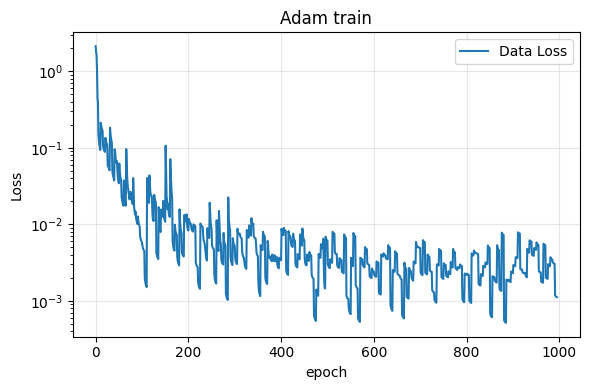

In [85]:
# ИНИЦИАЛИЗАЦИЯ
model = GrossPitaevskiiPINN(x,y,
        dataset.x_max, dataset.x_min,
        dataset.y_max, dataset.y_min,
        dataset.t_max, dataset.t_min,
        dataset.ox_std, dataset.ox_mean,
        dataset.oy_std, dataset.oy_mean,
        dataset.g_std, dataset.g_mean,
        dataset.psi_std, dataset.psi_mean,
        layers_main=[6, 250, 250, 250, 250, 250, 250, 250, 2],
        device="cuda",
        physics_weight=0,
        norm_weight=0.1,
        update_freq = 10,
        norm_check_freq=1000
)

model.train_adam(
    loader = dataloader,
    num_iterations = 10000,
    learning_rate = 1e-3,
    step_size = 1000
)


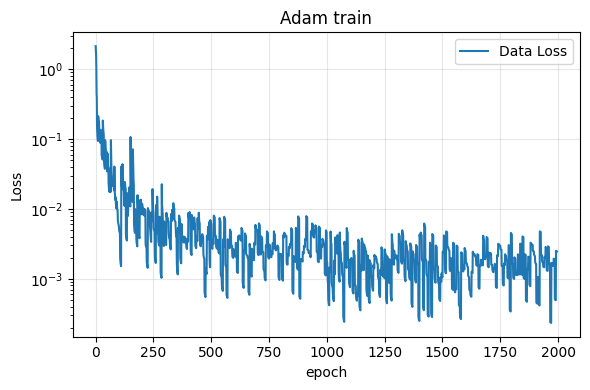

In [86]:
model.train_adam(
    loader = dataloader,
    num_iterations = 10000,
    learning_rate = 1e-4,
    step_size = 1000
)

In [89]:
save_dir = "/content/drive/MyDrive/PINN_nlse/model_results/data_driven_ResNet/"
import os
os.makedirs(save_dir, exist_ok=True)

iteration = 9500

torch.save({
    "model_state": model.main_net.state_dict(),
    "optimizer_state": model.optimizer.state_dict(),
    "iteration": iteration
}, os.path.join(save_dir, f"checkpoint_iter_{iteration}.pt"))

In [90]:
model.main_net.eval()

GrossPitaevskiiDNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=6, out_features=250, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=250, out_features=250, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=250, out_features=250, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=250, out_features=250, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=250, out_features=250, bias=True)
    (activation_4): Tanh()
    (layer_5): Linear(in_features=250, out_features=250, bias=True)
    (activation_5): Tanh()
    (layer_6): Linear(in_features=250, out_features=250, bias=True)
    (activation_6): Tanh()
    (layer_7): Linear(in_features=250, out_features=2, bias=True)
  )
)

In [91]:
del model

In [92]:
del dataset

In [82]:
import gc
gc.collect()
if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# Учим с loss_physics с нуля

Настройки dataset:

num_traj_per_batch=20

n_data_per_traj=3000

n_f_per_traj=10000

Смена батча раз в 100 итераций

Вес крайне маленький, так как у сети есть склонность игнорировать data (причина?)

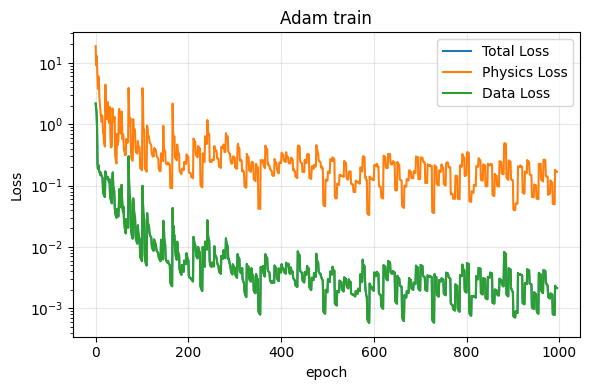

In [96]:
# ИНИЦИАЛИЗАЦИЯ
model = GrossPitaevskiiPINN(x,y,
        dataset.x_max, dataset.x_min,
        dataset.y_max, dataset.y_min,
        dataset.t_max, dataset.t_min,
        dataset.ox_std, dataset.ox_mean,
        dataset.oy_std, dataset.oy_mean,
        dataset.g_std, dataset.g_mean,
        dataset.psi_std, dataset.psi_mean,
        layers_main=[6, 250, 250, 250, 250, 250, 250, 250, 2],
        device="cuda",
        physics_weight=0.0001,
        norm_weight=0.1,
        update_freq = 10,
        norm_check_freq=1000
)

model.train_adam(
    loader = dataloader,
    num_iterations = 10000,
    learning_rate = 1e-3,
    step_size = 1000
)


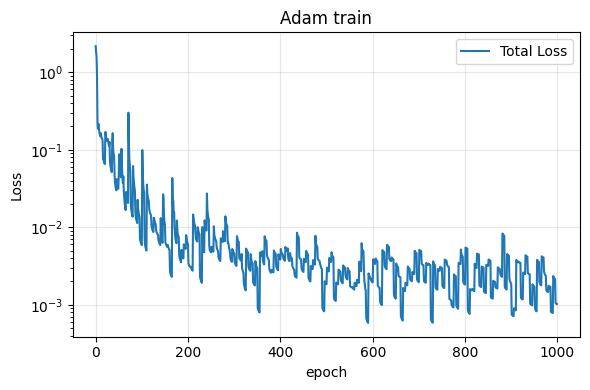

In [103]:
plt.figure(figsize=(6, 4))
plt.plot(model.loss_history["total"], label='Total Loss')
#plt.plot(model.loss_history["physics"], label='Physics Loss')
#plt.plot(model.loss_history["data"], label='Data Loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Adam train")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()